<h1>MNIST_Recognizer_CNN<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing libraries</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Resize-and-rescale-data-in-jpg-format" data-toc-modified-id="Resize-and-rescale-data-in-jpg-format-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Resize and rescale data in jpg format</a></span></li><li><span><a href="#Split-into-Target-and-Features" data-toc-modified-id="Split-into-Target-and-Features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Split into Target and Features</a></span></li><li><span><a href="#Check-for-null-and-missing-values" data-toc-modified-id="Check-for-null-and-missing-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check for null and missing values</a></span></li><li><span><a href="#Normalize-data" data-toc-modified-id="Normalize-data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Normalize data</a></span></li><li><span><a href="#Reshape" data-toc-modified-id="Reshape-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Reshape</a></span></li><li><span><a href="#Encode-target" data-toc-modified-id="Encode-target-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Encode target</a></span></li><li><span><a href="#Split-into-train-and-validation-set" data-toc-modified-id="Split-into-train-and-validation-set-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Split into train and validation set</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data augmentation</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Training-and-validation-curves" data-toc-modified-id="Training-and-validation-curves-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Training and validation curves</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Explore-the-errors" data-toc-modified-id="Explore-the-errors-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Explore the errors</a></span></li></ul></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prediction</a></span></li></ul></div>

# Importing libraries

In [2]:
#Basic 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

np.random.seed(9)

In [3]:
#Specific

import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf

from keras.utils.np_utils import to_categorical #convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



Using TensorFlow backend.


In [4]:
#GPU testing 

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print(tf.test.is_built_with_cuda())

Default GPU Device: /device:GPU:0
True


# Data Preparation 

## Load data 

In [51]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [10]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Resize and rescale data in jpg format

In [55]:
train_path='mnist_png/training/'
test_path='mnist_png/testing/'

#from keras.preprocessing import image
datagen=ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False) 


datagen.fit(X_train)

train_generator=datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    interpolation="bilinear",
)

test_generator=datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    interpolation="bilinear",
)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


## Split into Target and Features

In [53]:
y_train=train['label']
X_train=train.drop(columns='label')

In [7]:
# free some space
del train 

Check balance in the target varible

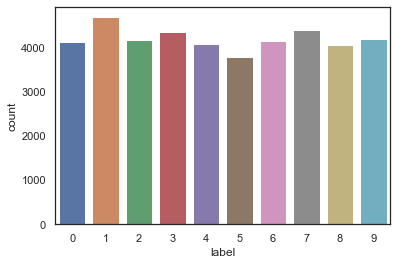

In [8]:
sns.countplot(y_train)

The dataset is balanced

## Check for null and missing values

In [9]:
X_train.isna().any().sum()

0

In [10]:
test.isna().any().sum()

0

## Normalize data

In [11]:
X_train /=255.0
test /=255.0

## Reshape

In [54]:
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

## Encode target

In [13]:
#Cross-entropy loss needs OHE for target
y_train=to_categorical(y_train,num_classes=10)

## Split into train and validation set

In [14]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size = 0.1, random_state=2)

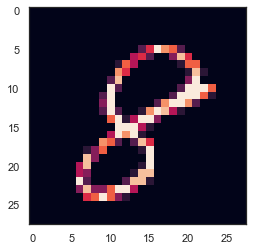

In [15]:
plt.imshow(X_train[0][:,:,0])

In [48]:
X_train.shape

(37800, 28, 28, 1)

# Modeling

## Define the model

In [31]:
#Import pre-trained model InceptionV3
from keras.applications import InceptionV3

#Instantiate convolutional base
conv_base = InceptionV3(weights='imagenet', 
                        include_top=False,
                        input_shape=(224, 224, 3))  # 3 = number of channels in RGB pictures


87916544/87910968 [==============================] - 196s 2us/step


In [33]:
#Forbid training of conv part
conv_base.trainable=False
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [34]:
#Build model
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
batch_normalization_95 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 34,913,834
Trainable params: 13,110,538
Non-trainable params: 21,803,296
_________________________________

In [36]:
# Define the optimizer
optimizer = RMSprop(lr=0.000001, rho=0.9, epsilon=1e-08, decay=0.0) 
#lr - learning rate, rho - Discounting factor for the history/coming gradient, epsilon - is added in formula for numerical stability, decay - decreasing of lr 

In [37]:
# Compile the model
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=['accuracy'] )

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [38]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [39]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

## Data augmentation

In [ ]:
# Without data augmentation:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1


In [ ]:
# With data augmentation to prevent overfitting:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [45]:
train_generator.class_indices


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [56]:
history = model.fit_generator(train_generator,
                              epochs = 3, validation_data = test_generator,
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/3
 - 864s - loss: 0.7519 - accuracy: 0.7590 - val_loss: 1.6059 - val_accuracy: 0.3822
Epoch 2/3


KeyboardInterrupt: 

# Evaluation 

## Training and validation curves

In [ ]:
fig,ax=plt.subplots(2,figsize=(10,10))

ax[0].plot(history.history['loss'],color='b',label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend(loc='best')

## Confusion matrix

In [ ]:
# Predict the values from the validation dataset
y_pred=model.predict(X_val)

In [ ]:
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1)
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 

accuracy=tf.keras.metrics.Accuracy()
accuracy.update_state(y_true, y_pred_classes)
print('Validation accuracy:', round(float(accuracy.result()),4))

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_mtx,annot=True, fmt='d')

'4' is most difficult case)

## Explore the errors

In [ ]:
#(Stolen from Kaggle))
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0) #It is like a mask

Y_pred_classes_errors = y_pred_classes[errors]
Y_pred_errors = y_pred[errors]
Y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Prediction

In [ ]:
results=model.predict(test)

In [ ]:
# select the index with the maximum probability
results=np.argmax(results,axis=1)

In [ ]:
#Proper format for output submission
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST_Recognizer_CNN.csv",index=False)